In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pylab as plt
import yfinance
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model

# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import sklearn as sk
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## 1. Data cleaning

<i> Asset data <i/>

In [2]:
# downloaded the data, calculated returns and converted date into pandas date format 

bond = pd.read_csv('bond.csv',parse_dates=True)
# bond returns are calculated in the excel file itself (summation of price change and interest)
bond['date'] = pd.to_datetime(bond.date) 

equity = pd.read_csv('equity.csv',parse_dates=True)
equity['equity_ret'] = equity.adj_close.pct_change()
equity['date']= pd.to_datetime(equity.date)

forex = pd.read_csv('forex.csv',parse_dates=True)
forex['forex_ret'] = forex.adj_close.pct_change()
forex['date'] = pd.to_datetime(forex.date)

gc = pd.read_csv('gc.csv',parse_dates=True)
gc['gc_ret'] = gc.adj_close.pct_change()
gc['date'] = pd.to_datetime(gc.date)

In [3]:
# Combined return data

combined = pd.concat([bond.set_index('date'),equity.set_index('date'),forex.set_index('date'),\
                      gc.set_index('date')],axis=1, join='inner')

returns = combined.loc[:,['bond_ret','equity_ret','forex_ret','gc_ret']]
returns.reset_index(inplace=True)

returns['year'] = returns['date'].dt.year
returns['month'] = returns['date'].dt.month
returns['quarter'] = returns.month.apply(lambda v: 'Q1' if v <=3 else 'Q2' if v<=6 else 'Q3' if v<=9 else 'Q4')
returns['year_quarter'] = returns.year.astype(str) + '-' + returns.quarter.astype(str)

returns.tail()

,date,bond_ret,equity_ret,forex_ret,gc_ret,year,month,quarter,year_quarter
9538,2020-04-24,-0.000022,0.013918,-0.000498,-0.011749,2020,4,Q2,2020-Q2
9539,2020-04-27,0.000010,0.014714,-0.003387,-0.000525,2020,4,Q2,2020-Q2
9540,2020-04-28,0.000028,-0.005242,-0.001699,-0.013644,2020,4,Q2,2020-Q2
9541,2020-04-29,0.000028,0.026584,-0.003004,0.006976,2020,4,Q2,2020-Q2
9542,2020-04-30,0.000028,-0.009212,-0.005524,-0.000352,2020,4,Q2,2020-Q2


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001896C1CC4C8>,
      dtype=object)

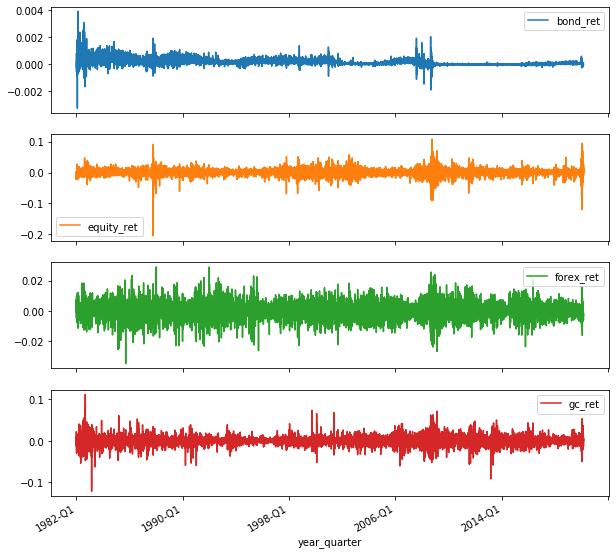

In [4]:
returns.set_index('year_quarter')[['bond_ret','equity_ret','forex_ret','gc_ret']].plot(subplots=True, figsize=(10,10))
pass

<i> Macro-economic factors <i/>

In [5]:
infl = pd.read_csv('inflation.csv')
# inflation already in terms of growth rate
infl['end_date'] = pd.to_datetime(infl.end_date)

gdp = pd.read_csv('gdp.csv')
gdp['gdp_gw_rate'] = gdp.adj_value_gdp.pct_change() 
gdp['end_date'] = pd.to_datetime(gdp.end_date)

unemp = pd.read_csv('unemp.csv')
unemp['unemp_gw_rate'] = unemp.adj_value_unemp.pct_change(3) # converting monthly to quarterly returns
unemp['end_date'] = pd.to_datetime(unemp.end_date)

In [6]:
macroeco = pd.concat([infl.set_index('end_date'),gdp.set_index('end_date'),\
                      unemp.set_index('end_date')],axis=1, join='inner')
macroeco = macroeco.loc[:,['infl_gw_rate','gdp_gw_rate','unemp_gw_rate']]
macroeco.reset_index(inplace=True)
macroeco['month'] = macroeco.end_date.dt.month
macroeco['year'] = macroeco.end_date.dt.year
macroeco['quarter'] = macroeco.month.apply(lambda v: 'Q1' if v==3 else 'Q2' if v==6 else 'Q3' if v==9 else 'Q4')
macroeco['year_quart'] = macroeco.year.astype(str) + '-' + macroeco.quarter.astype(str)

In [7]:
macroeco.head()

,end_date,infl_gw_rate,gdp_gw_rate,unemp_gw_rate,month,year,quarter,year_quart
0,1960-03-31,-0.113379,0.026576,0.019984,3,1960,Q1,1960-Q1
1,1960-06-30,0.567537,-0.002890,0.010735,6,1960,Q2,1960-Q2
2,1960-09-30,0.225734,0.008361,0.031333,9,1960,Q3,1960-Q3
3,1960-12-31,0.675676,-0.009910,0.188723,12,1960,Q4,1960-Q4
4,1961-03-31,0.000000,0.008925,0.051115,3,1961,Q1,1961-Q1


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001896E31CBC8>,
      dtype=object)

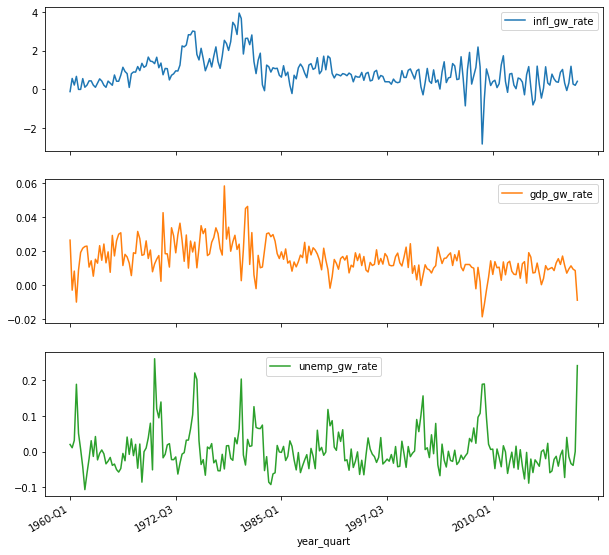

In [8]:
macroeco.set_index('year_quart')[['infl_gw_rate','gdp_gw_rate','unemp_gw_rate']].plot(subplots=True, figsize=(10,10))
pass

## 3. Quarterly correlation matrix

In [9]:
# creating a dictionary with keys as the quarter and values as correlation between assets for that quarter
CORR_YQ = {}
COV_YQ = {}
for year in range(1982, 2021):
    for quarter in range(1,5):
        sub3 = returns[(returns['year'] == year) & (returns['quarter'] == ('Q'+str(quarter)))]
        CORR_YQ[str(year)+'-'+'Q'+str(quarter)] = sub3[['equity_ret','bond_ret','forex_ret', 'gc_ret']].corr()
        COV_YQ[str(year)+'-'+'Q'+str(quarter)] = sub3[['equity_ret','bond_ret','forex_ret', 'gc_ret']].cov()

# Creating a list with quarter names and relevant correlation values
Xq = []
Yq = []

for year_quarter in sorted(COV_YQ.keys()):
    cov_ravelled = np.ravel(COV_YQ[year_quarter])
    Xq += [year_quarter]
    Yq += [cov_ravelled[[(1,2,3,6,7,11)]]]        
             
# Creating a dataframe with quarter lables and relevant correlation values
pairs_q = {1:('Bond','SP500'),2:('Forex','SP500'),3:('Gold','SP500'),
         6: ('Forex','Bond'),7: ('Gold','Bond'),11: ('Gold','Forex')}

report_q = []

for year_quarter in sorted(COV_YQ.keys()):
    cov_q = np.ravel(COV_YQ[year_quarter])
    
    for i in (1,2,3,6,7,11):
        r = {'year_quarter': year_quarter,
             'symbol_1': pairs_q[i][0],
             'symbol_2': pairs_q[i][1],
             'cov': cov_q[i]}
        report_q += [r]

df_cov_quarter = pd.DataFrame(report_q)

# Dataframe with combination value 
df_cov_quarter['combination'] = df_cov_quarter.symbol_1 + " & " + df_cov_quarter.symbol_2
data_q = pd.DataFrame(columns= df_cov_quarter.combination.unique(),index = df_cov_quarter.year_quarter.unique(),data = Yq)
data_qt = data_q.transpose()
data_qt = data_qt.iloc[:,:-2]

In [12]:
fig = go.Figure(data=go.Heatmap(
        z=data_qt,
        x=data_qt.columns.unique(),
        y=df_cov_quarter.combination.unique(),
        colorscale=['red','green']))
fig.update_layout(
    title='Covariance between assets from 1982-Q1 to 2020-Q1',
    xaxis_nticks=50)
fig.show()

## 4. Combining assets and macro-economic factors

In [13]:
combined_df = pd.concat([macroeco.set_index('year_quart'),data_q],axis=1, join='inner')
combinedall = combined_df.loc[:,['infl_gw_rate','gdp_gw_rate','unemp_gw_rate','Bond & SP500', 'Forex & SP500', 'Gold & SP500',
       'Forex & Bond', 'Gold & Bond', 'Gold & Forex']]
combinedall['regimes'] = combinedall.apply(lambda m: \
                        '+GDP+Infl+Unemp' if ((m.gdp_gw_rate>=0)&(m.infl_gw_rate>=0)&(m.unemp_gw_rate>=0)) else
                        '+GDP+Infl-Unemp' if ((m.gdp_gw_rate>=0)&(m.infl_gw_rate>=0)&(m.unemp_gw_rate<0)) else
                        '+GDP-Infl+Unemp' if ((m.gdp_gw_rate>=0)&(m.infl_gw_rate<0)&(m.unemp_gw_rate>=0)) else
                        '+GDP-Infl-Unemp' if ((m.gdp_gw_rate>=0)&(m.infl_gw_rate<0)&(m.unemp_gw_rate<0)) else
                        '-GDP+Infl+Unemp' if ((m.gdp_gw_rate<0)&(m.infl_gw_rate>=0)&(m.unemp_gw_rate>=0)) else
                        '-GDP+Infl-Unemp' if ((m.gdp_gw_rate<0)&(m.infl_gw_rate>=0)&(m.unemp_gw_rate<0)) else
                        '-GDP-Infl+Unemp' if ((m.gdp_gw_rate<0)&(m.infl_gw_rate<0)&(m.unemp_gw_rate>=0)) else
                        '-GDP-Infl-Unemp' if ((m.gdp_gw_rate<0)&(m.infl_gw_rate<0)&(m.unemp_gw_rate<0)) else 'NA', axis=1)
combinedall.regimes.value_counts(dropna = False)

+GDP+Infl-Unemp    85
+GDP+Infl+Unemp    50
-GDP+Infl+Unemp     6
+GDP-Infl-Unemp     6
+GDP-Infl+Unemp     4
-GDP-Infl+Unemp     2
Name: regimes, dtype: int64

-GDP+Infl-Unemp and -GDP-Infl-Unemp not observed. We have considered percentage change in unemployment. Hence this means when GDP goes down, unemployment always goes up, atleast for the period under consideration.

### +GDP+Infl-Unemp

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001897018E988>,
      dtype=object)

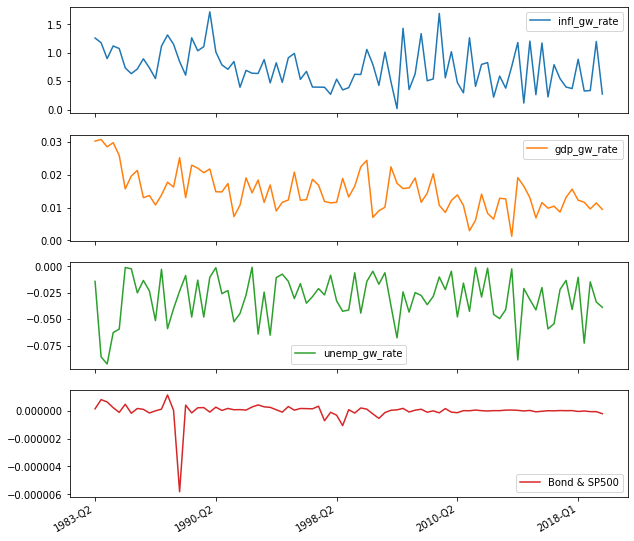

In [14]:
combinedall[combinedall.regimes=='+GDP+Infl-Unemp'].iloc[:,:4].plot(figsize=(10,10), subplots=True)
pass

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001896FF406C8>,
      dtype=object)

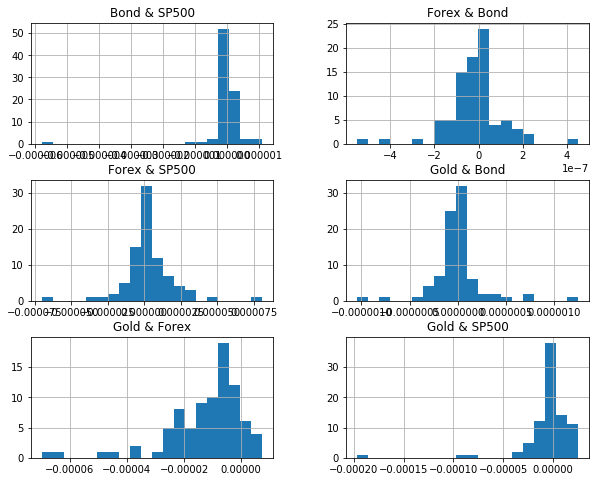

In [15]:
combinedall[combinedall.regimes=='+GDP+Infl-Unemp'].iloc[:,3:].hist(bins=20,figsize=(10,8))
pass

In [16]:
combinedall[combinedall.regimes=='+GDP+Infl-Unemp'].iloc[:,3:-1].aggregate([min,np.mean,np.std,np.median,max]).round(2)

,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex
min,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
mean,-0.0,0.0,-0.0,-0.0,0.0,-0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
median,0.0,0.0,-0.0,-0.0,0.0,-0.0
max,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
combinedall[combinedall.regimes=='+GDP+Infl-Unemp'].iloc[:,3:-1].describe()

,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex
count,8.500000e+01,85.000000,85.000000,8.500000e+01,8.500000e+01,85.000000
mean,-4.111041e-08,0.000003,-0.000006,-2.008642e-08,8.158199e-09,-0.000012
std,6.868154e-07,0.000017,0.000028,1.254778e-07,2.676569e-07,0.000014
min,-5.803896e-06,-0.000070,-0.000197,-5.481074e-07,-1.044788e-06,-0.000070
25%,-9.403733e-08,-0.000003,-0.000009,-7.089085e-08,-6.225828e-08,-0.000017
50%,7.450349e-09,0.000002,-0.000002,-5.772600e-09,1.142611e-09,-0.000009
75%,1.359242e-07,0.000010,0.000004,1.719205e-08,5.885361e-08,-0.000004
max,1.110823e-06,0.000081,0.000025,4.474498e-07,1.245539e-06,0.000007


### +GDP+Infl+Unemp

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018970610588>,
      dtype=object)

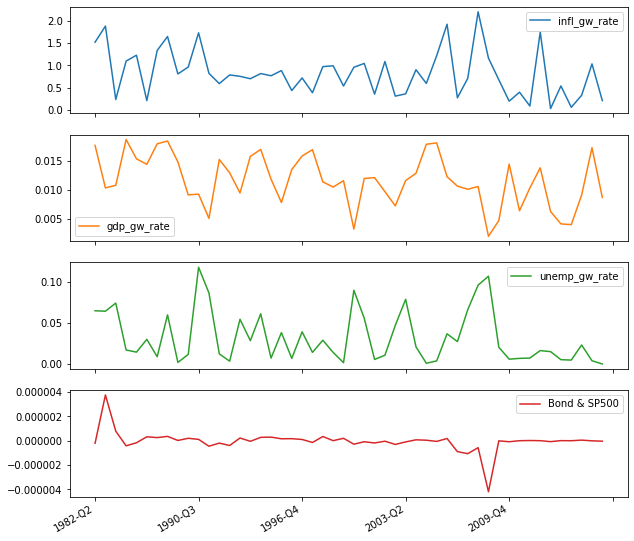

In [18]:
combinedall[combinedall.regimes=='+GDP+Infl+Unemp'].iloc[:,:4].plot(figsize=(10,10), subplots=True)
pass

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018970571508>,
      dtype=object)

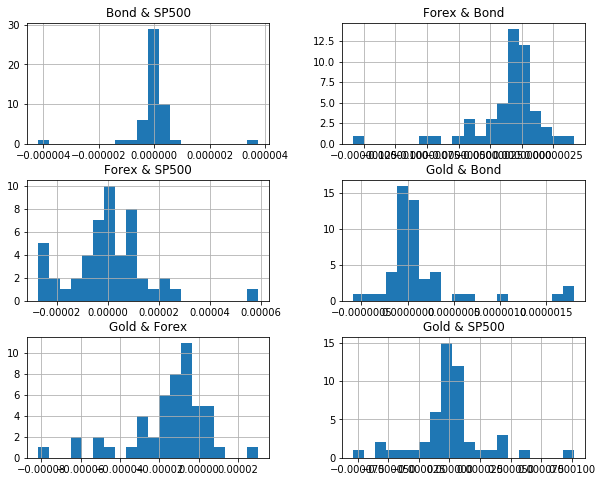

In [19]:
combinedall[combinedall.regimes=='+GDP+Infl+Unemp'].iloc[:,3:].hist(bins=20,figsize=(10,8))
pass

In [20]:
combinedall[combinedall.regimes=='+GDP+Infl+Unemp'].iloc[:,3:-1].aggregate([min,np.mean,np.std,np.median,max]).round(2)

,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex
min,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
mean,-0.0,0.0,0.0,-0.0,0.0,-0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
median,-0.0,-0.0,0.0,-0.0,0.0,-0.0
max,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
combinedall[combinedall.regimes=='+GDP+Infl+Unemp'].iloc[:,3:-1].describe()

,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,50.000000
mean,-4.461537e-08,8.545531e-08,3.744850e-07,-1.161325e-07,1.493687e-07,-0.000015
std,8.592676e-07,1.570872e-05,2.875299e-05,2.773694e-07,4.665326e-07,0.000020
min,-4.192218e-06,-2.741230e-05,-7.854158e-05,-1.331566e-06,-5.872389e-07,-0.000082
25%,-1.653175e-07,-6.056760e-06,-8.224183e-06,-1.604424e-07,-4.297013e-08,-0.000021
50%,-3.320236e-09,-3.294514e-07,1.062884e-06,-5.765148e-08,1.862058e-08,-0.000010
75%,1.623040e-07,8.651158e-06,6.356165e-06,5.231454e-09,1.662580e-07,-0.000004
max,3.752082e-06,5.915162e-05,1.015606e-04,4.103626e-07,1.796619e-06,0.000030


## 5. ACF and PACF plots for different coorelation combinations

In [22]:
combinedall.head()

,infl_gw_rate,gdp_gw_rate,unemp_gw_rate,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex,regimes
1982-Q1,0.818214,-0.001986,0.067767,1.996689e-06,-0.000008,0.000058,-1.581449e-06,2.140632e-06,-0.000012,-GDP+Infl+Unemp
1982-Q2,1.517290,0.017613,0.064982,-2.108421e-07,-0.000012,0.000025,-4.015487e-07,1.079246e-06,-0.000019,+GDP+Infl+Unemp
1982-Q3,1.876955,0.010309,0.064433,3.752082e-06,-0.000025,0.000102,-1.331566e-06,1.712027e-06,-0.000082,+GDP+Infl+Unemp
1982-Q4,0.238826,0.010765,0.074351,7.795368e-07,-0.000014,0.000044,-7.777863e-07,1.796619e-06,-0.000049,+GDP+Infl+Unemp
1983-Q1,-0.068074,0.020823,-0.053357,6.965017e-08,-0.000013,0.000051,-1.911057e-07,-3.197250e-07,-0.000052,+GDP-Infl-Unemp


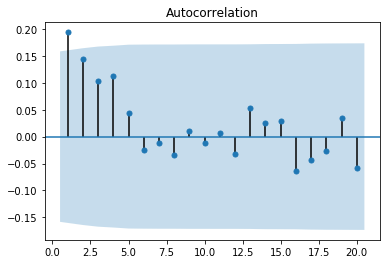

Text(0.5, 1, 'ACF of Bond & SP500 correlation')

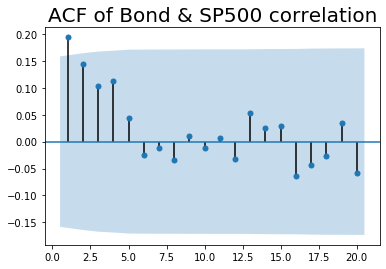

In [23]:
sgt.plot_acf(combinedall['Bond & SP500'], zero = False, lags = 20)
plt.title("ACF of Bond & SP500 correlation",size=20)
plt.show()

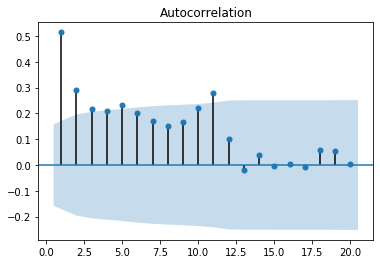

Text(0.5, 1, 'ACF of Forex & SP500 correlation')

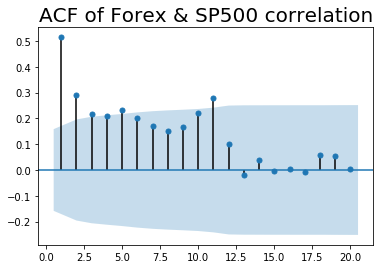

In [24]:
sgt.plot_acf(combinedall['Forex & SP500'], zero = False, lags = 20)
plt.title("ACF of Forex & SP500 correlation",size=20)
plt.show()

In [22]:
# need to be done for other combinations

## 5. ARIMAX model


In [25]:
# Bond and SP500

# tried adding unemployment rate as the exogenous variable

arimax_model_unemp = ARIMA(combinedall['Bond & SP500'], 
                     exog = combinedall.unemp_gw_rate,
                     order = (2,0,2))
results_arimax_unemp = arimax_model_unemp.fit()
results_arimax_unemp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Bond & SP500   No. Observations:                  153
Model:                     ARMA(2, 2)   Log Likelihood                1940.376
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 08 Jul 2020   AIC                          -3866.751
Time:                        16:18:11   BIC                          -3845.538
Sample:                    01-01-1982   HQIC                         -3858.134
                         - 01-01-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.201e-08   8.34e-08     -0.743      0.457   -2.25e-07    1.01e-07
unemp_gw_rate      -2.774e-06   1.29e-06     -2.155      0.031    -5.3e-06   -2.52e-07
ar.L1.Bond & SP500     0.0702        nan        nan        nan         nan         nan
ar.L2.Bond & SP500     0.0436      0.569      0.077      0.939      -1.071       1.158
ma.L1.Bond & SP500     0.0702        nan        nan        nan         nan         nan
ma.L2.Bond & SP500     0.0436      0.471      0.093      0.926      -0.880       0.967
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.0508           +0.0000j            4.0508            0.0000
AR.2           -5.6600           +0.0000j            5.6600            0.5000
MA.1           -0.8046           -4.7202j            4.7883           -0.2769
MA.2           -0.8046           +4.7202j            4.7883            0.2769
-----------------------------------------------------------------------------
"""

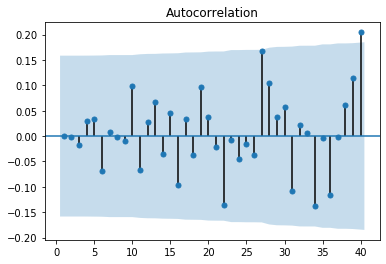

Text(0.5, 1, 'ACF Of Residuals of Bond&SP500 corr with exog Unemp')

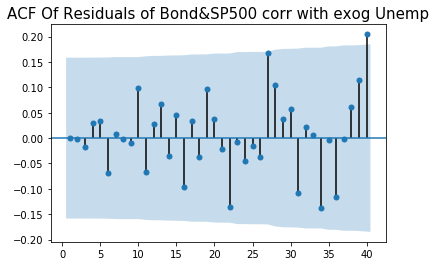

In [24]:
res_arimax_unemp = results_arimax_unemp.resid
sgt.plot_acf(res_arimax_unemp, zero = False, lags = 40)
plt.title("ACF Of Residuals of Bond&SP500 corr with exog Unemp",size=15)
plt.show()

In [25]:
# Bond and SP 500

# tried adding GDP rate as the exogenous variable

arimax_model_gdp = ARIMA(combinedall['Bond & SP500'], 
                     exog = combinedall.gdp_gw_rate,
                     order = (2,0,2))
results_arimax_gdp = arimax_model_gdp.fit()
results_arimax_gdp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Bond & SP500   No. Observations:                  153
Model:                     ARMA(2, 2)   Log Likelihood                  59.009
Method:                       css-mle   S.D. of innovations              0.164
Date:                Wed, 08 Jul 2020   AIC                           -104.019
Time:                        10:49:09   BIC                            -82.806
Sample:                    01-01-1982   HQIC                           -95.402
                         - 01-01-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0025      0.043      0.059      0.953      -0.082       0.087
gdp_gw_rate           -0.1932      2.519     -0.077      0.939      -5.130       4.744
ar.L1.Bond & SP500     0.0238      0.196      0.121      0.903      -0.360       0.408
ar.L2.Bond & SP500     0.5087      0.186      2.739      0.006       0.145       0.873
ma.L1.Bond & SP500     0.2002      0.216      0.928      0.354      -0.223       0.623
ma.L2.Bond & SP500    -0.1189      0.200     -0.594      0.553      -0.511       0.273
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3789           +0.0000j            1.3789            0.0000
AR.2           -1.4256           +0.0000j            1.4256            0.5000
MA.1           -2.1779           +0.0000j            2.1779            0.5000
MA.2            3.8611           +0.0000j            3.8611            0.0000
-----------------------------------------------------------------------------
"""

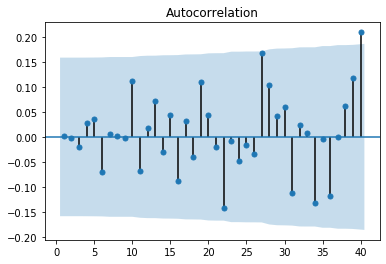

Text(0.5, 1, 'ACF Of Residuals of Bond&SP500 corr with exog GDP')

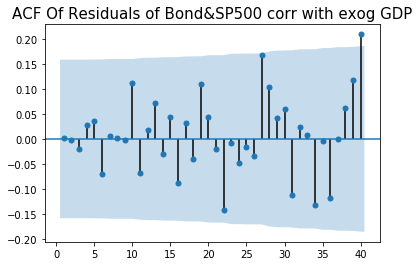

In [26]:
res_arimax_gdp = results_arimax_gdp.resid
sgt.plot_acf(res_arimax_gdp, zero = False, lags = 40)
plt.title("ACF Of Residuals of Bond&SP500 corr with exog GDP",size=15)
plt.show()

In [27]:
# tried converting regimes into categorical variable and use it as the exog input

from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df2 = combinedall.copy()
df2['regimes']=lb_make.fit_transform(df2['regimes'])
df2.regimes.value_counts()


1    85
0    50
4     6
3     6
2     4
5     2
Name: regimes, dtype: int64

In [28]:
arimax_regimes = ARIMA(df2['Bond & SP500'], 
                     exog = df2.regimes,
                     order = (2,0,2))
results_arimax_regimes = arimax_regimes.fit()
results_arimax_regimes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Bond & SP500   No. Observations:                  153
Model:                     ARMA(2, 2)   Log Likelihood                  59.007
Method:                       css-mle   S.D. of innovations              0.164
Date:                Wed, 08 Jul 2020   AIC                           -104.014
Time:                        10:49:10   BIC                            -82.801
Sample:                    01-01-1982   HQIC                           -95.397
                         - 01-01-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0002      0.032     -0.005      0.996      -0.064       0.063
regimes                0.0003      0.012      0.028      0.978      -0.023       0.024
ar.L1.Bond & SP500     0.0220      0.196      0.113      0.910      -0.361       0.405
ar.L2.Bond & SP500     0.5098      0.188      2.715      0.007       0.142       0.878
ma.L1.Bond & SP500     0.2000      0.218      0.915      0.360      -0.228       0.628
ma.L2.Bond & SP500    -0.1227      0.199     -0.617      0.537      -0.513       0.267
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3791           +0.0000j            1.3791            0.0000
AR.2           -1.4224           +0.0000j            1.4224            0.5000
MA.1           -2.1538           +0.0000j            2.1538            0.5000
MA.2            3.7831           +0.0000j            3.7831            0.0000
-----------------------------------------------------------------------------
"""

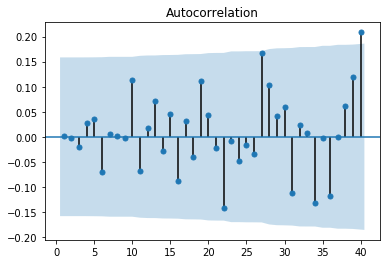

Text(0.5, 1, 'ACF Of Residuals of Bond&SP500 corr with categorical regimes as exog')

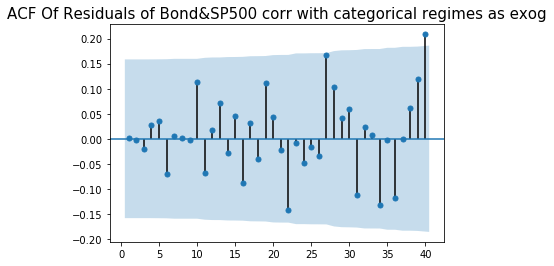

In [29]:
res_arimax_regimes = results_arimax_regimes.resid
sgt.plot_acf(res_arimax_regimes, zero = False, lags = 40)
plt.title("ACF Of Residuals of Bond&SP500 corr with categorical regimes as exog",size=15)
plt.show()

<b><i> Trying ARIMAX model for Bond & SP500 correlation, adding all macro-economic factors as exogenous variables

In [30]:
arimax_model_macroeco = ARIMA(combinedall['Bond & SP500'], 
                     exog = combinedall[['gdp_gw_rate','unemp_gw_rate','infl_gw_rate']],
                     order = (2,0,2))
results_arimax_macroeco = arimax_model_macroeco.fit()
results_arimax_macroeco.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Bond & SP500   No. Observations:                  153
Model:                     ARMA(2, 2)   Log Likelihood                  59.285
Method:                       css-mle   S.D. of innovations              0.164
Date:                Wed, 08 Jul 2020   AIC                           -100.570
Time:                        10:49:11   BIC                            -73.296
Sample:                    01-01-1982   HQIC                           -89.491
                         - 01-01-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0081      0.046     -0.175      0.861      -0.099       0.083
gdp_gw_rate            0.1152      2.987      0.039      0.969      -5.738       5.969
unemp_gw_rate          0.1872      0.356      0.526      0.599      -0.510       0.884
infl_gw_rate           0.0096      0.021      0.448      0.654      -0.032       0.051
ar.L1.Bond & SP500     0.0280      0.195      0.143      0.886      -0.355       0.411
ar.L2.Bond & SP500     0.5066      0.183      2.767      0.006       0.148       0.865
ma.L1.Bond & SP500     0.2051      0.214      0.956      0.339      -0.215       0.625
ma.L2.Bond & SP500    -0.1063      0.195     -0.544      0.586      -0.489       0.277
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3777           +0.0000j            1.3777            0.0000
AR.2           -1.4329           +0.0000j            1.4329            0.5000
MA.1           -2.2508           +0.0000j            2.2508            0.5000
MA.2            4.1805           +0.0000j            4.1805            0.0000
-----------------------------------------------------------------------------
"""

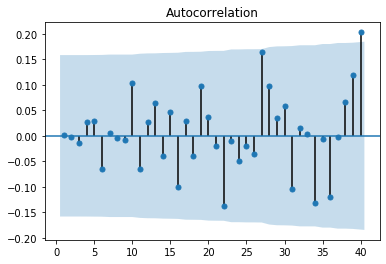

Text(0.5, 1, 'ACF Of Residuals of Bond&SP500 corr with all macroeco factors as exog')

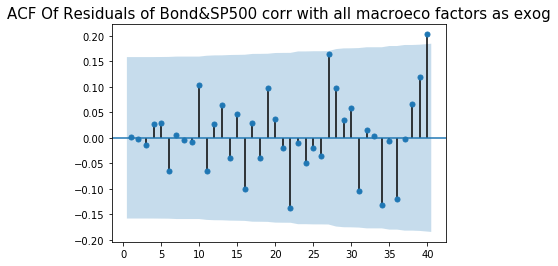

In [31]:
res_arimax_macroeco = results_arimax_macroeco.resid
sgt.plot_acf(res_arimax_macroeco, zero = False, lags = 40)
plt.title("ACF Of Residuals of Bond&SP500 corr with all macroeco factors as exog",size=15)
plt.show()

Testing the results

In [32]:
combined_df['regimes'] = combinedall['regimes']
combined_df.set_index('end_date',inplace=True)
combined_df.head()

,infl_gw_rate,gdp_gw_rate,unemp_gw_rate,month,year,quarter,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex,regimes
end_date,,,,,,,,,,,,,
1982-03-31,0.818214,-0.001986,0.067767,3,1982,Q1,0.199004,-0.170585,0.383209,-0.329875,0.143122,-0.161102,-GDP+Infl+Unemp
1982-06-30,1.517290,0.017613,0.064982,6,1982,Q2,-0.048714,-0.306788,0.182098,-0.141025,0.105668,-0.207316,+GDP+Infl+Unemp
1982-09-30,1.876955,0.010309,0.064433,9,1982,Q3,0.339797,-0.326359,0.284872,-0.229541,0.064504,-0.436096,+GDP+Infl+Unemp
1982-12-31,0.238826,0.010765,0.074351,12,1982,Q4,0.120391,-0.179832,0.153034,-0.339520,0.209176,-0.485275,+GDP+Infl+Unemp
1983-03-31,-0.068074,0.020823,-0.053357,3,1983,Q1,0.023968,-0.225484,0.203968,-0.124499,-0.047433,-0.395632,+GDP-Infl-Unemp


Text(0.5, 1.0, 'Predictions vs Actual (Returns)')

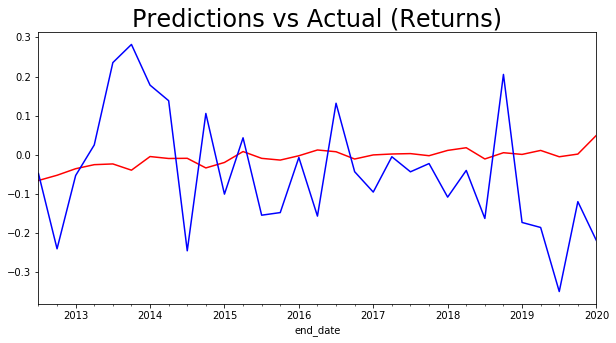

In [33]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(combined_df, test_size=0.2, shuffle=False)


arimax_macroeco_train = ARIMA(train['Bond & SP500'], 
                     exog = train[['gdp_gw_rate','unemp_gw_rate','infl_gw_rate']],
                     order = (2,0,2))
results_arimax_macroeco_train = arimax_macroeco_train.fit()


start_date = '2012-09-30'
end_date = '2020-03-31'

pred_armax = results_arimax_macroeco_train.predict(start = start_date, end = end_date, 
                                          exog = test[['gdp_gw_rate','unemp_gw_rate','infl_gw_rate']][start_date:end_date]) 

pred_armax[start_date:end_date].plot(figsize = (10,5), color = "red")
test['Bond & SP500'][start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

## 6. GARCH Model

In [34]:
garch_1_1 = arch_model(combinedall['Bond & SP500'], mean = "Constant", vol = "GARCH", p = 2, q = 1)
results_garch_1_1 = garch_1_1.fit()
results_garch_1_1.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: -43.22119815818034
Iteration:      2,   Func. Count:     18,   Neg. LLF: -43.2589845894816
Iteration:      3,   Func. Count:     26,   Neg. LLF: -43.58726690535392
Iteration:      4,   Func. Count:     35,   Neg. LLF: -43.63646484923703
Iteration:      5,   Func. Count:     43,   Neg. LLF: -43.72141542270661
Iteration:      6,   Func. Count:     51,   Neg. LLF: -43.92628634756184
Iteration:      7,   Func. Count:     59,   Neg. LLF: -43.943206048381406
Iteration:      8,   Func. Count:     67,   Neg. LLF: -43.975305349907394
Iteration:      9,   Func. Count:     75,   Neg. LLF: -43.982380878059715
Iteration:     10,   Func. Count:     82,   Neg. LLF: -43.98936433340707
Iteration:     11,   Func. Count:     90,   Neg. LLF: -43.99137421661665
Iteration:     12,   Func. Count:     98,   Neg. LLF: -43.99434259827827
Iteration:     13,   Func. Count:    105,   Neg. LLF: -43.99460508931594
Iteration:     14,   Func. Count:    112,   Neg. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Bond & SP500   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                43.9946
Distribution:                  Normal   AIC:                          -77.9892
Method:            Maximum Likelihood   BIC:                          -62.8370
                                        No. Observations:                  153
Date:                Wed, Jul 08 2020   Df Residuals:                      148
Time:                        10:49:12   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.4008e-04  1.682e-02 -5.589e-02      0.955 [-3.391e-02,3.203e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0112  9.272e-03      1.205      0.228 [-6.997e-03,2.935e-02]
alpha[1]   1.7621e-03      0.130  1.355e-02      0.989      [ -0.253,  0.257]
alpha[2]       0.2590      0.131      1.970  4.882e-02    [1.341e-03,  0.517]
beta[1]        0.4257      0.327      1.302      0.193      [ -0.215,  1.067]
=============================================================================

Covariance estimator: robust
"""

Testing the model

In [35]:
train_garch, test_garch = train_test_split(combined_df, test_size=0.2, shuffle=False)


garch_1_1_train = arch_model(train['Bond & SP500'], mean = "Constant", vol = "GARCH", p = 2, q = 1)
results_garch_1_1_train = garch_1_1_train.fit()

fc_garch = results_garch_1_1_train.forecast(horizon=31)
pred_y = fc_garch.variance.values[-1,:]
actual_y = (test['Bond & SP500']-np.mean(train['Bond & SP500']))**2

Iteration:      1,   Func. Count:      7,   Neg. LLF: -29.937545296353736
Iteration:      2,   Func. Count:     18,   Neg. LLF: -29.95175115047058
Iteration:      3,   Func. Count:     26,   Neg. LLF: -30.47342203232736
Iteration:      4,   Func. Count:     35,   Neg. LLF: -30.479239728336022
Iteration:      5,   Func. Count:     42,   Neg. LLF: -30.666647737283704
Iteration:      6,   Func. Count:     49,   Neg. LLF: -31.066933003180495
Iteration:      7,   Func. Count:     57,   Neg. LLF: -31.133209009267347
Iteration:      8,   Func. Count:     64,   Neg. LLF: -31.291428730947562
Iteration:      9,   Func. Count:     71,   Neg. LLF: -31.29673001035616
Iteration:     10,   Func. Count:     78,   Neg. LLF: -31.297086954737573
Iteration:     11,   Func. Count:     85,   Neg. LLF: -31.297169991164306
Iteration:     12,   Func. Count:     92,   Neg. LLF: -31.297174538259387
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -31.29717457231085
     

Text(0.5, 1.0, 'GARCH Model\nActual vs Predicted')

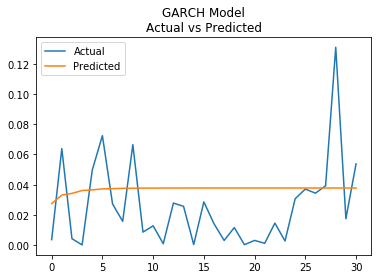

In [36]:
plt.plot(actual_y.tolist(), label='Actual')
plt.plot(pred_y, label='Predicted')
plt.legend()
plt.title('GARCH Model\nActual vs Predicted')
plt.show()

## 7. Linear Regression

In [26]:
# Calculating quarterly bond return

bond = bond.set_index('date').asfreq('d').fillna(method='ffill')
bond['price'] = 1 - (bond['adj_close']/100*90/360)

bond_qrt_return = bond['price'].resample('Q').ffill().pct_change()
bond_qrt_return = pd.DataFrame(bond_qrt_return)
bond_qrt_return.columns = ['price_return']

bond_df = pd.concat([bond,bond_qrt_return],axis=1,join='inner')
bond_df['int_return'] = bond_df['adj_close'].shift(1)*90/360/100
bond_df['total_qt_return'] = bond_df['price_return']+bond_df['int_return']

In [27]:
# Calculating and collating quarterly returns for all asset classes

start_date = '1982-03-31'
end_date = '2020-03-31'

eq_qrt_ret = equity.set_index('date')['adj_close'].resample('Q').ffill().pct_change()
bond_qrt_ret = bond_df['total_qt_return'][start_date:end_date]
gold_qrt_ret = gc.set_index('date')['adj_close'].resample('Q').ffill().pct_change()
forex_qrt_ret = forex.set_index('date')['adj_close'].resample('Q').ffill().pct_change()

qrt_ret = pd.DataFrame(data = (eq_qrt_ret,bond_qrt_ret,gold_qrt_ret,forex_qrt_ret))
qrt_ret = qrt_ret.transpose()
qrt_ret.columns = ['eq_qrt_ret','bond_qrt_ret','gold_qrt_ret','forex_qrt_ret']

qrt_ret = qrt_ret[start_date:end_date]

In [35]:
combinedall

,infl_gw_rate,gdp_gw_rate,unemp_gw_rate,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex,regimes
1982-Q1,0.818214,-0.001986,0.067767,1.996689e-06,-8.310713e-06,0.000058,-1.581449e-06,2.140632e-06,-0.000012,-GDP+Infl+Unemp
1982-Q2,1.517290,0.017613,0.064982,-2.108421e-07,-1.166507e-05,0.000025,-4.015487e-07,1.079246e-06,-0.000019,+GDP+Infl+Unemp
1982-Q3,1.876955,0.010309,0.064433,3.752082e-06,-2.543024e-05,0.000102,-1.331566e-06,1.712027e-06,-0.000082,+GDP+Infl+Unemp
1982-Q4,0.238826,0.010765,0.074351,7.795368e-07,-1.373889e-05,0.000044,-7.777863e-07,1.796619e-06,-0.000049,+GDP+Infl+Unemp
1983-Q1,-0.068074,0.020823,-0.053357,6.965017e-08,-1.276814e-05,0.000051,-1.911057e-07,-3.197250e-07,-0.000052,+GDP-Infl-Unemp
...,...,...,...,...,...,...,...,...,...,...
2019-Q1,0.335116,0.009619,-0.014636,-7.982244e-08,-1.182071e-06,-0.000003,4.856326e-09,3.305805e-09,-0.000006,+GDP+Infl-Unemp
2019-Q2,1.198513,0.011443,-0.033742,-8.132942e-08,-1.821719e-06,-0.000004,-5.135518e-08,1.185189e-07,-0.000006,+GDP+Infl-Unemp
2019-Q3,0.274166,0.009478,-0.038764,-2.249922e-07,8.621939e-06,-0.000023,-7.089085e-08,1.719909e-07,-0.000009,+GDP+Infl-Unemp
2019-Q4,0.213018,0.008661,0.000000,-4.224318e-08,9.999286e-07,-0.000010,-3.847055e-08,1.157303e-07,-0.000004,+GDP+Infl+Unemp


In [34]:
macro_and_assets = pd.concat([qrt_ret,combined_df.set_index('end_date')],axis=1,join='inner')
macro_and_assets = macro_and_assets [['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret', 'Bond & SP500',
       'Forex & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Bond',
       'Gold & Forex', 'regimes']]
macro_and_assets.head(2)

KeyError: "['regimes'] not in index"

In [76]:
# creating dummies for regimes
combined_dummy = macro_and_assets.copy()
combined_dummy['+GDP+Infl-Unemp'] = (combined_dummy['regimes'] == '+GDP+Infl-Unemp')*1
combined_dummy['+GDP+Infl+Unemp'] = (combined_dummy['regimes'] == '+GDP+Infl+Unemp')*1

combined_dummy.drop(columns=['regimes'],inplace=True)


reg1_df = combined_dummy.copy()

# creating lag 1 for returns
reg1_df['eq_qrt_ret'] = reg1_df['eq_qrt_ret'].shift(1)
reg1_df['bond_qrt_ret'] = reg1_df['bond_qrt_ret'].shift(1)
reg1_df['gold_qrt_ret'] = reg1_df['gold_qrt_ret'].shift(1)
reg1_df['forex_qrt_ret'] = reg1_df['forex_qrt_ret'].shift(1)


# creating lag 2 for correlation combinations
reg1_df['Bond & SP500_lag'] = reg1_df['Bond & SP500'].shift(3)
reg1_df['Forex & SP500'] = reg1_df['Forex & SP500'].shift(3)
reg1_df['Gold & SP500'] = reg1_df['Gold & SP500'].shift(3)
reg1_df['Forex & Bond'] = reg1_df['Forex & Bond'].shift(3)
reg1_df['Gold & Bond'] = reg1_df['Gold & Bond'].shift(3)
reg1_df['Gold & Forex'] = reg1_df['Gold & Forex'].shift(3)


reg1_df = reg1_df.dropna()

In [77]:
reg1_df.head(2)

,eq_qrt_ret,bond_qrt_ret,gold_qrt_ret,forex_qrt_ret,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex,+GDP+Infl-Unemp,+GDP+Infl+Unemp,Bond & SP500_lag
1982-12-31,0.098622,0.047573,0.250394,0.026546,0.120391,-0.170585,0.383209,-0.329875,0.143122,-0.161102,0,1,0.199004
1983-03-31,0.167912,0.018884,0.150882,-0.039607,0.023968,-0.306788,0.182098,-0.141025,0.105668,-0.207316,0,0,-0.048714


ADF Statistic: -4.827962
p-value: 0.000048
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577

We reject the Null Hypothesis (H0) -- the time series is stationary


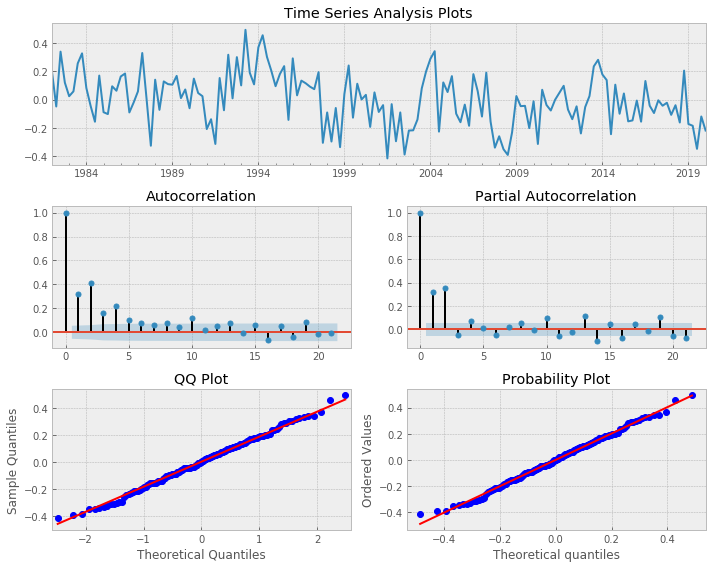

In [65]:
testing.ts_plot(macro_and_assets['Bond & SP500'],lags=21)

In [71]:
# defining X and Y variables

X = reg1_df [['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret',
       'Forex & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Bond', 'Gold & Forex', 'Bond & SP500_lag',
              '+GDP+Infl-Unemp','+GDP+Infl+Unemp']].values
Y = reg1_df['Bond & SP500'].values

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Training the model
regressor = LinearRegression()
regressor.fit(x_train, y_train)

print ('Constant : ' + str(regressor.intercept_))

coeff_df = pd.DataFrame(regressor.coef_,['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret',
       'Forex & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Bond', 'Gold & Forex','Bond & SP500_lag',
              '+GDP+Infl-Unemp','+GDP+Infl+Unemp'],columns=['Coefficient'])
coeff_df

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Constant : -0.00545959010078151


,Coefficient
eq_qrt_ret,0.141457
bond_qrt_ret,1.095710
gold_qrt_ret,-0.180103
forex_qrt_ret,-0.164984
Forex & SP500,0.021156
Gold & SP500,0.033570
Forex & Bond,-0.177534
Gold & Bond,0.063055
Gold & Forex,0.117298
Bond & SP500_lag,0.156403


In [43]:
# Predicted values V/s actual values

y_pred = regressor.predict(x_test)
print('Mean Squared error : ' + str( metrics.mean_squared_error(y_test, y_pred)))
print('Sqrt of mean squared error : ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

Mean Squared error : 0.022761215949663176
Sqrt of mean squared error : 0.15086820721962324


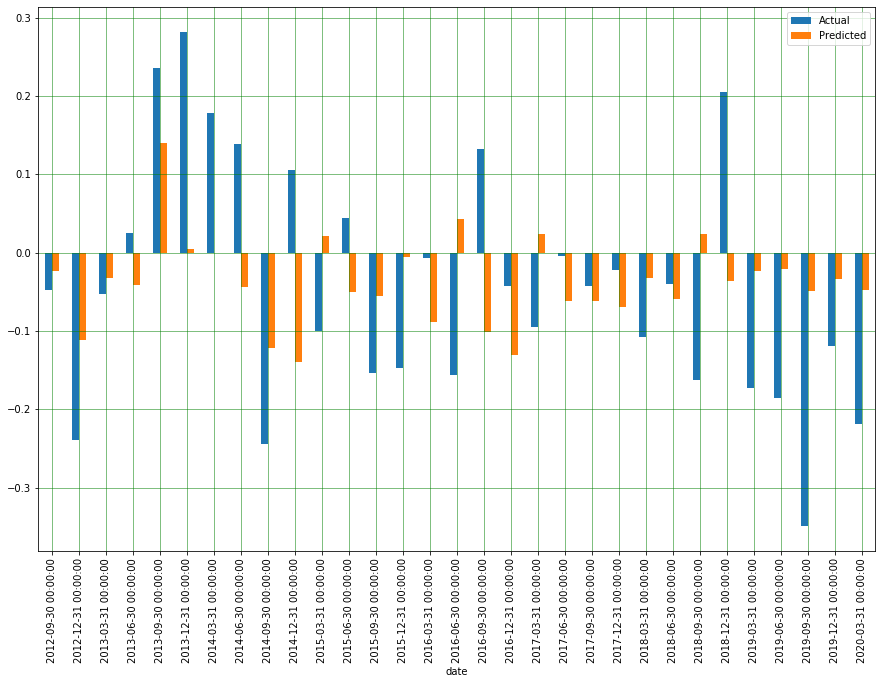

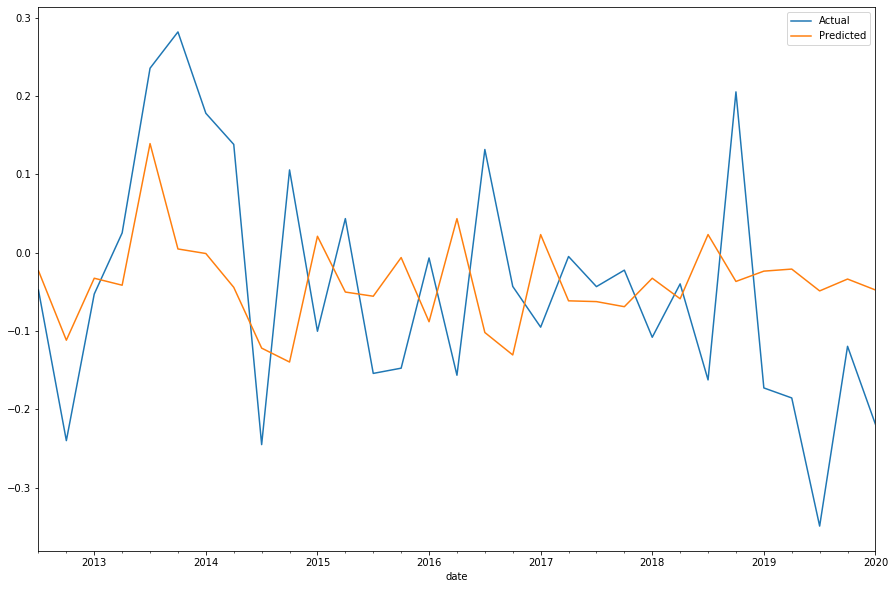

In [60]:
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df['date'] = reg1_df.index.values[-31:]
results_df.set_index('date',inplace=True)

results_df.plot(kind='bar',figsize=(15,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

results_df.plot(figsize=(15,10))
plt.show()

In [64]:
# check lags in returns and correlation
import testing

## 8. Clustering

In [80]:
from sklearn.cluster import KMeans
clu = KMeans(n_clusters =3)
clu.fit(combined_dummy.dropna())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [83]:
df3 = combined_dummy.dropna().copy()
df3['cluster'] = clu.labels_
df3.groupby('cluster').mean()

,eq_qrt_ret,bond_qrt_ret,gold_qrt_ret,forex_qrt_ret,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex,+GDP+Infl-Unemp,+GDP+Infl+Unemp
cluster,,,,,,,,,,,,
0,-0.004355,0.006963,0.002274,0.004341,-0.026114,-0.061394,0.005891,-0.072085,0.014226,-0.284011,0,0
1,0.026042,0.009384,0.011702,0.001882,0.008727,0.047993,-0.048290,-0.039214,0.006293,-0.259847,1,0
2,0.030398,0.011763,0.019303,-0.004564,-0.006219,-0.014905,-0.008326,-0.092813,0.024049,-0.251799,0,1
